In [19]:
using DifferentialEquations, LinearAlgebra, SparseArrays,Sundials,CUDA,PreallocationTools,SciMLSensitivity
using SparseDiffTools,Symbolics
using BenchmarkTools
using DelimitedFiles
using Plots
using CUDA.CUSPARSE

In [20]:
function GCH_2D_mul_cpu(du, u, p, t,ψ,∇x,∇y,∇2x,∇2y,∇ψ_x,∇ψ_y,∇c_x,∇c_y,∇2c,μ,∇2μ,∇μ_x,∇μ_y)
    D, κ, Ω, J=p
    c = @view u[:,:]
    dc = @view du[:,:]
    
    #Set up caches from DiffCache
    ∇c_x_t = get_tmp(∇c_x,u)
    ∇c_y_t = get_tmp(∇c_y,u)
    ∇2c_t = get_tmp(∇2c,u)
    μ_t = get_tmp(μ,u)
    ∇2μ_t = get_tmp(∇2μ,u)
    ∇μ_x_t = get_tmp(∇μ_x,u)
    ∇μ_y_t = get_tmp(∇μ_y,u)
    
    #Compute ∇c
    mul!(∇c_x_t,∇x,c) # Compute (∇c)ₓ = ∇x*c
    #@show findmax(∇c_x_t)
    mul!(∇c_y_t,c,∇y) # Compute (∇c)_y = c*∇y
    #show findmax(∇c_y_t)
    #Compute ∇2c
    mul!(∇2c_t,∇2x,c) # Compute (∇2c)ₓ = c*∇2x
    mul!(∇2c_t,c,∇2y,1.0,1.0) #∇2c = 1*(∇2c)ₓ + 1*(∇2y)*c
    #@show findmax(∇2c_t)
    @. μ_t = log(max(1e-6,c./(1.0 - c)))+ Ω*(1.0 - 2.0*c) .- κ*((∇c_x_t*∇ψ_x  + ∇c_y_t*∇ψ_y)./ψ + ∇2c_t);
    #@show findmax(μ_t)
    #@. μ_t = Ω*(1.0 - 2.0*c) .- κ*(∇2c_t);
    #Compute ∇2μ
    mul!(∇2μ_t,∇2x,μ_t) # Compute (∇2μ)ₓ = μ*∇2x
    mul!(∇2μ_t,μ_t,∇2y,1.0,1.0) #∇2μ = 1*(∇2μ)ₓ + 1*(∇2y)*μ
    #@show findmax(∇2μ_t)
    #Compute ∇μ
    mul!(∇μ_x_t,∇x,μ_t) # Compute (∇μ)ₓ = ∇x*μ
    #@show findmax(∇μ_x_t)
    mul!(∇μ_y_t,μ_t,∇y) # Compute (∇μ)_y = μ*∇y
    #@show findmax(∇μ_x_t)
    # @. dc = D*(c*(1.0-c)*((∇ψ_x*∇μ_x_t + ∇ψ_y*∇μ_y_t)./ψ + ∇2μ_t) + (1.0-2.0*c)*(∇c_x_t*∇μ_x_t + ∇c_y_t*∇μ_y_t))
    @. dc = D*(c*(1.0-c)*(∇2μ_t) + (1.0-2.0*c)*(∇c_x_t*∇μ_x_t + ∇c_y_t*∇μ_y_t))
    #@show findmax(dc)
    return nothing
end

GCH_2D_mul_cpu (generic function with 1 method)

In [21]:

ψ = readdlm("psi.csv")
ψ_binary = readdlm("psi_b.csv")
ψ = ψ[end:-1:1, :]
ψ_binary = ψ_binary[end:-1:1, :]
Nx, Ny = size(ψ)
x = LinRange(0.0, 1, Nx)
y = LinRange(0.0, 1, Ny)
dx = x[2] - x[1]
dy = y[2] - y[1]

D = 0.1
κ = 0.001
Ω = 3.0
J = -0.1

c0 = readdlm("goodc0.csv")
tspan = (0.0, 1)
dc0 = similar(c0);

In [22]:
Nx, Ny = size(ψ)
x = LinRange(0.0, 1, Nx)
y = LinRange(0.0, 1, Ny)
dx = x[2] - x[1]
dy = y[2] - y[1]

D = 1f-1
κ = 1f-3
Ω = 3f0

p = [D,κ, Ω,J];

∇2x = Tridiagonal([1.0 for i in 1:Nx-1],[-2.0 for i in 1:Nx],[1.0 for i in 1:Nx-1])
∇2x[1,2] = 2.0
∇2x[end,end-1] = 2.0
∇2y= deepcopy(∇2x)
∇2y = ∇2y'

∇x= Tridiagonal([-1.0 for i in 1:Nx-1],[0.0 for i in 1:Nx],[1.0 for i in 1:Nx-1]);
∇x[1,2]=0.0
∇x[end,end-1]=0.0

∇y= Tridiagonal([-1.0 for i in 1:Ny-1],[0.0 for i in 1:Ny],[1.0 for i in 1:Ny-1]);
∇y[1,2]=0.0
∇y[end,end-1]=0.0
∇y =∇y'


∇2x ./= dx^2;
∇2y ./= dy^2;
∇x ./= 2*dx;
∇y ./= 2*dy;

# ∇2x=Array(∇2x)
# ∇2y=Array(∇2y)
# ∇x=Array(∇x)
# ∇y=Array(∇y)
dampcoeff=1;
damp_factor = dampcoeff*norm(ψ);
∇ψ_x = (∇x*ψ)
∇ψ_y=(ψ*∇y)



∇c_x=zeros(Nx,Ny);
∇c_y=zeros(Nx,Ny);
∇2c=zeros(Nx,Ny);
μ = zeros(Nx,Ny);
∇2μ=zeros(Nx,Ny);
∇μ_x=zeros(Nx,Ny);
∇μ_y=zeros(Nx,Ny);

chunk_size = 256;

∇c_x_c = DiffCache(∇c_x)
∇c_y_c = DiffCache(∇c_y)
∇2c_c = DiffCache(∇2c)
μ_c = DiffCache(μ)
∇2μ_c = DiffCache(∇2μ)
∇μ_x_c = DiffCache(∇μ_x)
∇μ_y_c = DiffCache(∇μ_y)

c0_c =deepcopy(c0)
dc0_c = similar(c0_c)

GCH_2D_mul_c!(du,u,p,t) = GCH_2D_mul_cpu(du, u, p, t,ψ,∇x,∇y,∇2x,∇2y,∇ψ_x,∇ψ_y,∇c_x_c,∇c_y_c,∇2c_c,μ_c,∇2μ_c,∇μ_x_c,∇μ_y_c)


GCH_2D_mul_c! (generic function with 1 method)

In [23]:
@time jac_sparsity = Symbolics.jacobian_sparsity((du, u) -> GCH_2D_mul_c!(du,u,p,0),dc0_c,c0_c);
colorvec = matrix_colors(jac_sparsity);
f = ODEFunction(GCH_2D_mul_c!;jac_prototype=jac_sparsity,colorvec=colorvec);
prob_c = ODEProblem(f,c0,(0.0,1.0),p);

  4.650550 seconds (39.29 M allocations: 2.305 GiB, 7.62% gc time, 68.59% compilation time)


In [24]:
@benchmark sol = solve(prob_c,CVODE_BDF(linear_solver=:GMRES),save_everystep=false)

BenchmarkTools.Trial: 201 samples with 1 evaluation.
 Range (min … max):  24.360 ms …  28.416 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     24.910 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   24.940 ms ± 380.583 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ▁ ▄▁  ▁  ▁▃  ▁▁ █▃▁    ▁                               
  ▄▃▁▁▁▄▃█▆██▇██████▇▇██▇███▇█▆▇█▆▄▃▄▃▁▄▄▆▁▁▄▁▁▃▁▃▁▁▃▃▁▃▁▁▃▁▁▃ ▄
  24.4 ms         Histogram: frequency by time         25.9 ms <

 Memory estimate: 663.86 KiB, allocs estimate: 6429.

In [25]:
sol = solve(prob_c,ROCK2(),save_everystep=false)

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
 0.0
 1.0
u: 2-element Vector{Matrix{Float64}}:
 [0.5366764007515327 0.5266191080804261 … 0.5196974003625441 0.48205874045476527; 0.5393540439034791 0.5207173918583038 … 0.5137379599142022 0.5019623321746877; … ; 0.49730611197552144 0.5231724683004547 … 0.4609671122718525 0.5482654878987233; 0.48832131235933357 0.5182400625963216 … 0.5194941341560293 0.45285736959836964]
 [0.9010538417661432 0.8566980618784694 … 0.8362515878958792 0.900132566279595; 0.9034539818351291 0.8636564819992353 … 0.8350138389525761 0.8993867627860722; … ; 0.1295679000752467 0.1701571225481288 … 0.8878712043578914 0.9125717496415287; 0.14403149646743474 0.19772356169310218 … 0.8825513226624454 0.9105891686022017]

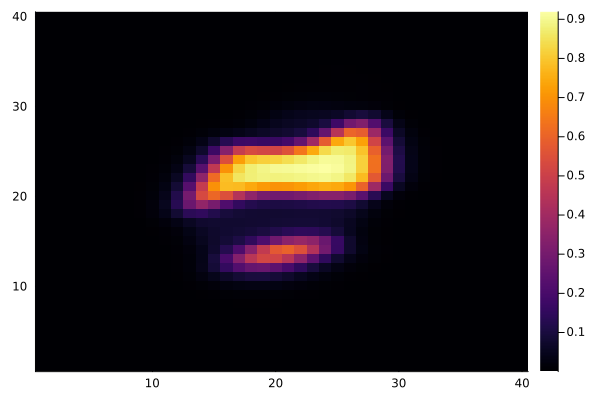

In [26]:
heatmap(sol.u[end].*ψ_binary)

In [27]:
@time sol=solve(prob_c,CVODE_BDF(linear_solver=:GMRES),save_everystep=false)

  0.024692 seconds (6.43 k allocations: 663.859 KiB)


retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
 0.0
 1.0
u: 2-element Vector{Matrix{Float64}}:
 [0.5366764007515327 0.5266191080804261 … 0.5196974003625441 0.48205874045476527; 0.5393540439034791 0.5207173918583038 … 0.5137379599142022 0.5019623321746877; … ; 0.49730611197552144 0.5231724683004547 … 0.4609671122718525 0.5482654878987233; 0.48832131235933357 0.5182400625963216 … 0.5194941341560293 0.45285736959836964]
 [0.9010541941491528 0.8566839214683163 … 0.8367483912564235 0.9003214432786631; 0.9034474128351458 0.8636353319143499 … 0.8354678448548756 0.8995621716902779; … ; 0.12803673584502898 0.16720187105919007 … 0.8888231368976017 0.912978992690729; 0.14176429328400839 0.19393822558786594 … 0.8836628520852827 0.9110062409669772]

# Now We Begin GPU set up & Testing

In [28]:
function GCH_2D_gpumul_full(du, u, p, t,ψ,∇x,∇y,∇2x,∇2y,∇ψ_x,∇ψ_y,∇c_x,∇c_y,∇2c,μ,∇2μ,∇μ_x,∇μ_y)
    D, κ, Ω=p
    c = @view u[:,:]
    dc = @view du[:,:]
    #Compute ∇c
    mul!(∇c_x,∇x,c) # Compute (∇c)ₓ = ∇x*c
    mul!(∇c_y,c,∇y) # Compute (∇c)_y = c*∇y
    
    #Compute ∇2c
    mul!(∇2c,∇2x,c) # Compute (∇2c)ₓ = c*∇2x
    mul!(∇2c,c,∇2y,1f0,1f0) #∇2c = 1*(∇2c)ₓ + 1*(∇2y)*c

    @. μ = CUDA.log(CUDA.max(1f-6,c./(1f0 - c))) + Ω*(1f0 - 2f0*c) - κ*((∇c_x*∇ψ_x  + ∇c_y*∇ψ_y)./ψ + ∇2c);
    #Compute ∇2μ
    mul!(∇2μ,∇2x,μ) # Compute (∇2μ)ₓ = μ*∇2x
    mul!(∇2μ,μ,∇2y,1.0,1.0) #∇2μ = 1*(∇2μ)ₓ + 1*(∇2y)*μ
    #Compute ∇μ
    mul!(∇μ_x,∇x,μ) # Compute (∇μ)ₓ = ∇x*μ
    mul!(∇μ_y,μ,∇y) # Compute (∇μ)_y = μ*∇y
    @. dc = D*(c*(1f0-c)*((∇ψ_x*∇μ_x + ∇ψ_y*∇μ_y)./ψ + ∇2μ) + (1f0 - 2f0*c)*(∇c_x*∇μ_x + ∇c_y*∇μ_y))
    return nothing
end

GCH_2D_gpumul_full (generic function with 1 method)

In [29]:
# function tridiagonal_dense_lmul_gpu!(C::CuArray{T}, A::CuArray{T}, B::CuArray{T}) where {T}
#     if size(A, 2) != size(B, 1)
#         throw(DimensionMismatch("matrix A has dimensions $(size(A)), matrix B has dimensions $(size(B))"))
#     end
#     if size(C, 1) != size(A, 1) || size(C, 2) != size(B, 2)
#         throw(DimensionMismatch("result C has dimensions $(size(C)), needs $((size(A, 1), size(B, 2)))"))
#     end
#     if isempty(A) || isempty(B)
#         return fill!(C, zero(T))
#     end

#     function kernel(C, A, B)
#         i = (blockIdx().x-1) * blockDim().x + threadIdx().x
#         j = (blockIdx().y-1) * blockDim().y + threadIdx().y

#         if i <= size(A, 1) && j <= size(B, 2)
#             Ctmp = zero(T)
#             for k in max(1, i - 1):min(size(A, 2), i + 1)
#                 Ctmp += A[i, k] * B[k, j]
#             end
#             C[i, j] = Ctmp
#         end

#         return
#     end

#     max_threads = 256
#     threads_x = min(max_threads, size(C, 1))
#     threads_y = min(max_threads ÷ threads_x, size(C, 2))
#     threads = (threads_x, threads_y)
#     blocks = ceil.(Int, (size(C, 1), size(C, 2)) ./ threads)

#     @cuda threads=threads blocks=blocks kernel(C, A, B)

#     return nothing
# end
# function tridiagonal_dense_rmul_gpu!(C::CuArray{T}, A::CuArray{T}, B::CuArray{T}) where {T}
#     if size(A, 2) != size(B, 1)
#         throw(DimensionMismatch("matrix A has dimensions $(size(A)), matrix B has dimensions $(size(B))"))
#     end
#     if size(C, 1) != size(A, 1) || size(C, 2) != size(B, 2)
#         throw(DimensionMismatch("result C has dimensions $(size(C)), needs $((size(A, 1), size(B, 2)))"))
#     end
#     if isempty(A) || isempty(B)
#         return fill!(C, zero(T))
#     end

#     function kernel(C, A, B)
#         i = (blockIdx().x-1) * blockDim().x + threadIdx().x
#         j = (blockIdx().y-1) * blockDim().y + threadIdx().y

#         if i <= size(A, 1) && j <= size(B, 2)
#             Ctmp = zero(T)
#             for k in max(1, i - 1):min(size(A, 2), i + 1)
#                 Ctmp += A[i, k] * B[k, j]
#             end
#             C[i, j] = Ctmp
#         end

#         return
#     end

#     max_threads = 256
#     threads_x = min(max_threads, size(C, 1))
#     threads_y = min(max_threads ÷ threads_x, size(C, 2))
#     threads = (threads_x, threads_y)
#     blocks = ceil.(Int, (size(C, 1), size(C, 2)) ./ threads)

#     @cuda threads=threads blocks=blocks kernel(C, A, B)

#     return nothing
# end

In [30]:
dc0_g = CuArray(Float32.(dc0))
c0_g = CuArray(Float32.(c0))
ψ_g = CuArray(Float32.(ψ))

∇x_g = CuArray(Float32.(∇x))
∇y_g = CuArray(Float32.(∇y))
∇2x_g = CuArray(Float32.(∇2x))
∇2y_g = CuArray(Float32.(∇2y))

∇ψ_x_g = CuArray(Float32.(∇ψ_x))
∇ψ_y_g = CuArray(Float32.(∇ψ_y))
∇c_x_g = CuArray(Float32.(∇c_x))
∇c_y_g = CuArray(Float32.(∇c_y))
∇2c_g = CuArray(Float32.(∇2c))
μ_g = CuArray(Float32.(μ))
∇2μ_g = CuArray(Float32.(∇2μ))
∇μ_x_g = CuArray(Float32.(∇μ_x))
∇μ_y_g = CuArray(Float32.(∇μ_y))

# ∇x_g=CuSparseMatrixCSC(∇x_g);
# ∇y_g=CuSparseMatrixCSC(∇y_g);
# ∇2x_g=CuSparseMatrixCSC(∇2x_g);
# ∇2y_g=CuSparseMatrixCSC(∇2y_g);

p_g = Float32(D), Float32(κ), Float32(Ω)

GCH_2D_GPU!(du,u,p,t) = GCH_2D_gpumul_full(du, u, p, t,ψ_g,∇x_g,∇y_g,∇2x_g,∇2y_g,∇ψ_x_g,∇ψ_y_g,∇c_x_g,∇c_y_g,∇2c_g,μ_g,∇2μ_g,∇μ_x_g,∇μ_y_g)
CUDA.allowscalar(false)

In [31]:
gpu_prob = ODEProblem(GCH_2D_GPU!,c0_g,(0f0,1f0),p_g);
CUDA.@time gpu_sol=solve(gpu_prob,ROCK2(),save_everystep=false)

  3.342114 seconds (12.27 M CPU allocations: 888.927 MiB, 2.84% gc time) (4.45 k GPU allocations: 125.945 KiB, 0.48% memmgmt time)


retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float32}:
 0.0
 1.0
u: 2-element Vector{CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}:
 [0.5366764 0.52661914 … 0.5196974 0.48205873; 0.539354 0.5207174 … 0.513738 0.5019623; … ; 0.4973061 0.5231725 … 0.46096712 0.5482655; 0.4883213 0.51824003 … 0.5194941 0.45285738]
 [0.8995857 0.86545604 … 0.87455934 0.9093081; 0.90333337 0.8748935 … 0.87908816 0.91108716; … ; 0.6994338 0.7029829 … 0.9061845 0.9265442; 0.838111 0.8400938 … 0.9232683 0.9357074]

In [32]:
CUDA.@time gpu_sol=solve(gpu_prob,ROCK2(),save_everystep=false)

  0.529904 seconds (1.06 M CPU allocations: 134.891 MiB) (4.45 k GPU allocations: 125.945 KiB, 3.39% memmgmt time)


retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float32}:
 0.0
 1.0
u: 2-element Vector{CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}:
 [0.5366764 0.52661914 … 0.5196974 0.48205873; 0.539354 0.5207174 … 0.513738 0.5019623; … ; 0.4973061 0.5231725 … 0.46096712 0.5482655; 0.4883213 0.51824003 … 0.5194941 0.45285738]
 [0.8995857 0.86545604 … 0.87455934 0.9093081; 0.90333337 0.8748935 … 0.87908816 0.91108716; … ; 0.6994338 0.7029829 … 0.9061845 0.9265442; 0.838111 0.8400938 … 0.9232683 0.9357074]

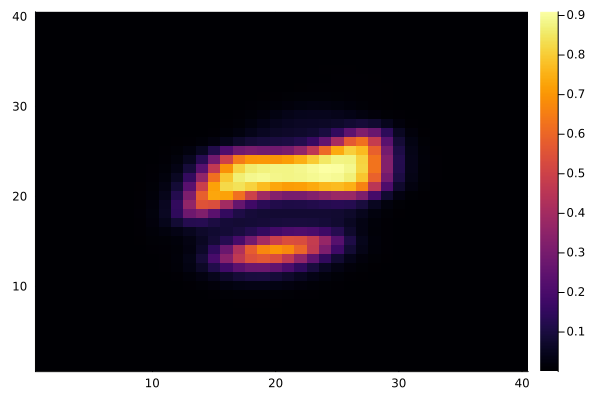

In [33]:
heatmap(Array(gpu_sol.u[end]).*ψ_binary)

In [34]:
@benchmark CUDA.@sync GCH_2D_GPU!($dc0_g,$c0_g,$p_g,0)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  123.800 μs …  32.096 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     146.700 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   201.164 μs ± 620.098 μs  ┊ GC (mean ± σ):  1.21% ± 0.92%

  ▄█▄▂▁                                                         ▁
  ██████▇▆▆▆▅▄▅▄▄▄▃▃▁▁▁▁▁▃▁▁▃▁▁▄▄▅▅▄▅▅▄▄▅▅▄▅▅▅▅▆▆▆▆▆▆▇▆▆▆▅▅▅▅▅▅ █
  124 μs        Histogram: log(frequency) by time       1.13 ms <

 Memory estimate: 49.62 KiB, allocs estimate: 289.